In [1]:
from IPython.display import display, Markdown
from datetime import datetime
cur_datetime = datetime.now()
display(Markdown(f'# {cur_datetime.strftime("%d/%b/%Y %H:%M")}'))

# 21/Oct/2020 17:43

In [2]:
%%capture
# %matplotlib inline

# Dependences
from time import time
# import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import numpy as np

# Experiments
import run

In [3]:
# Run all experiments. Typical run duration for an Core-i3 laptop is about 2-3min.
# Tweak the prey_predator_abm/sim_params.py file if you want it to take longer (or not).
start_time = time()
experiments = run.run()
end_time = time()
print("Execution in {:.1f}s".format(end_time - start_time))


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: multi_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (147437, 5, 1, 3)
Execution Method: single_proc_exec
Execution Mode: single_threaded
Total execution time: 23.60s
Execution in 24.2s


## ANALYSIS

In [4]:
model_history = experiments[['DAI_balance', 'ETH_balance', 'UNI_supply']]
model_history.columns = ['model_DAI_balance', 'model_ETH_balance', 'model_UNI_supply']

In [5]:
UNI_df = pd.read_pickle('./uniswap_events.pickle')
real_history = UNI_df.iloc[1:][['token_balance','eth_balance','UNI_supply']].reset_index(drop=True)
real_history.columns = ['real_DAI_balance', 'real_ETH_balance', 'real_UNI_supply']

<AxesSubplot:>

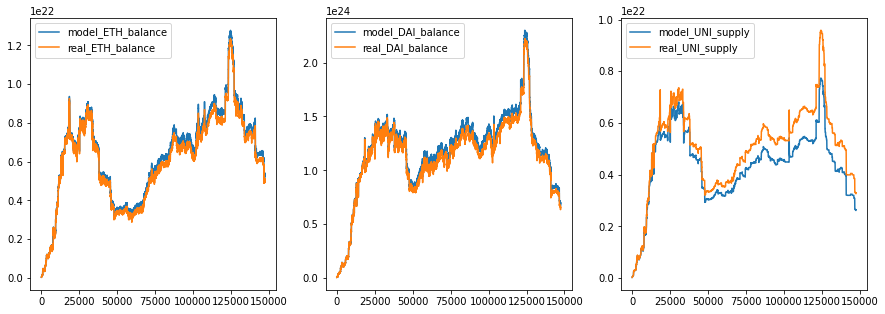

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
model_history.astype(float).plot(ax=ax, y=['model_ETH_balance'])
real_history.astype(float).plot(ax=ax, y=['real_ETH_balance'])
ax = plt.subplot(132)
model_history.astype(float).plot(ax=ax, y=['model_DAI_balance'])
real_history.astype(float).plot(ax=ax, y=['real_DAI_balance'])
ax = plt.subplot(133)
model_history.astype(float).plot(ax=ax, y=['model_UNI_supply'])
real_history.astype(float).plot(ax=ax, y=['real_UNI_supply'])

In [7]:
model_history.tail(1)

,model_DAI_balance,model_ETH_balance,model_UNI_supply
147437,700622565129079351328816,5299815888961482766422,2647865144672507188723


In [8]:
real_history.tail(1)

,real_DAI_balance,real_ETH_balance,real_UNI_supply
147437,662323537318822558984586,5009819142181678051370,3304234867026987131356


In [9]:
model_history.iloc[-1]['model_DAI_balance']/real_history.iloc[-1]['real_DAI_balance']

1.0578252555621028

In [10]:
model_history.iloc[-1]['model_ETH_balance']/real_history.iloc[-1]['real_ETH_balance']

1.0578856718275695

In [11]:
model_history.iloc[-1]['model_UNI_supply']/real_history.iloc[-1]['real_UNI_supply']

0.8013550038756615